In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import json
import dask
from dask import delayed, dataframe as dd
from dask.distributed import Client, LocalCluster
import bokeh
import glob
from itertools import chain
import matplotlib.pyplot as plt
import dask.config
from libpysal.weights import fuzzy_contiguity
import os

/tmp/ipykernel_5337/3384552129.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
with open('./out/singapore/what_cells_are_in_what_cluster_dict.json', 'r') as f:
    includes_dict = json.load(f)

In [3]:
chunks = gpd.read_parquet("./out/singapore/cluster_dissolved.pq")

In [4]:
w = fuzzy_contiguity(chunks, buffering=True, buffer=1000)

<Axes: >

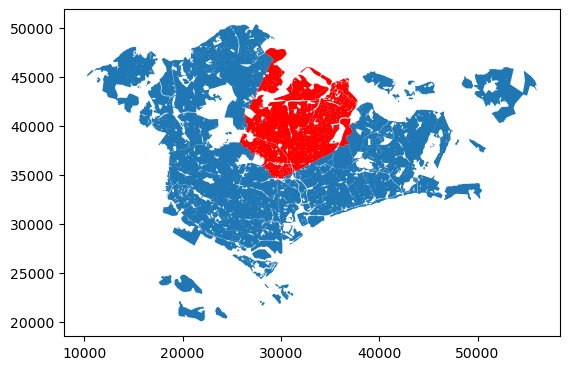

In [5]:
ax = chunks.loc[w.neighbors[2]].plot()
chunks.loc[[2]].plot(ax=ax, color='r')

In [6]:
dask.config.set(logging={'distributed': 'debug'})

daskCluster = LocalCluster(threads_per_worker=2,
                n_workers=8, memory_limit='100GB')

client = Client(daskCluster)

client

/home/virgilxw/miniconda3/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42173 instead
  warnings.warn(
2023-04-18 07:56:45,929 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-04-18 07:56:45,932 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-04-18 07:56:45,935 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-04-18 07:56:45,937 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-04-18 07:56:45,940 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-04-18 07:56:45,943 - distributed.nanny.memory - WARNING - Ignoring

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:42173/status,
Dashboard: http://127.0.0.1:42173/status,Workers: 8
Total threads: 16,Total memory: 250.47 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33135,Workers: 8
Dashboard: http://127.0.0.1:42173/status,Total threads: 16
Started: Just now,Total memory: 250.47 GiB
Comm: tcp://127.0.0.1:33807,Total threads: 2
Dashboard: http://127.0.0.1:45223/status,Memory: 31.31 GiB
Nanny: tcp://127.0.0.1:42429,


In [7]:
def duplicates(tessellation):

    # Check for duplicates based on UID
    duplicates = tessellation[tessellation.duplicated(subset='uID', keep=False)]

    # duplicates.to_file( "./out/" + place + 'errors.shp', driver='ESRI Shapefile')

    # Print the duplicate rows
    if len(duplicates) > 0:
        raise Exception("Tesselation: Duplicate UID entries:")
    elif (tessellation["uID"].isnull().values.any()):
        raise Exception("uID column include invalid entries")
    else:
        print("combined_chunk no problems")
        return 0

In [8]:
# queen_out = {}

# @delayed
# def neigh_look(cell, search_chunks): 
#     intersects = gpd.sjoin(search_chunks, cell, predicate='touches', how='inner')

#     return intersects.uID_left.tolist()


# def expand_one_order(n1, main_chunk_ids, periphery_cells_id, order, combined_chunks):
    
#     red_gdf = combined_chunks[combined_chunks['uID'].isin(periphery_cells_id)]
    
#     blue_gdf = combined_chunks[combined_chunks['uID'].isin(main_chunk_ids)]
    
#     # plot the GeoDataFrames on the same plot
#     fig, ax = plt.subplots(figsize=(4, 4))
#     combined_chunks.plot(ax=ax, color='lightgray')
#     blue_gdf.plot(ax=ax, color='blue')
#     red_gdf.plot(ax=ax, color='red')
#     plt.show()
#     print("starting expand_one_order, chunk " + str(n1) + " order " + str(order), flush=True)
            
#     if order == 0:
#         return main_chunk_ids

#     results = set(main_chunk_ids)
    
#     search_chunks = combined_chunks[~combined_chunks['uID'].isin(main_chunk_ids + periphery_cells_id)]
#     search_chunks_distributed = client.scatter(search_chunks)
    
#     chunk_size = 320
#     periphery_cells_id_chunks = [periphery_cells_id[i:i+chunk_size] for i in range(0, len(periphery_cells_id), chunk_size)]
    
#     len_sublist = len(periphery_cells_id_chunks)
    
    
#     for i, sublist in enumerate(periphery_cells_id_chunks):

#         delay_objs =[]
#         new_results = []
        
#         delay_objs = [neigh_look(combined_chunks[combined_chunks['uID'] == cell_id], search_chunks_distributed) for cell_id in sublist]
#         new_results = dask.compute(delay_objs)
#         {results.add(new) for new in chain(*new_results[0])}
            
                    
#         print("compute done this wave", flush=True)
#         print("chunk " + str(n1) + " , order " + str(order) +" , sublist " + str(i+1) + " of " + str(len_sublist), flush=True)
    
    
#     neighbouring_cells = list(results - set(main_chunk_ids))
    
#     # find the rows in main_chunk that intersect the buffered polygon
    
    
#     print("cells added this wave", flush=True)
    
#     return expand_one_order(n1, list(results), neighbouring_cells, order-1, combined_chunks)
    
# def process_chunk(n1, order, neighbours, chunk):
            
#     main_chunk = gpd.read_parquet(f"./out/singapore/tess_cells_in_cluster_{int(n1)}.pq")
#     combined_chunks = main_chunk

#     main_chunk_ids = list(main_chunk['uID'])

#     for n2 in neighbours:
#         neigh_chunk = gpd.read_parquet(f"./out/singapore/tess_cells_in_cluster_{int(n2)}.pq")
#         combined_chunks = combined_chunks.append(neigh_chunk)

#     combined_chunks = combined_chunks.reindex()
    
#     buffer = gpd.GeoDataFrame(geometry = [chunk.boundary[n1].buffer(5)], crs=main_chunk.crs)
    
#     # find the rows in main_chunk that intersect the buffered polygon
#     intersecting_rows = gpd.sjoin(main_chunk, buffer, how='inner', predicate='intersects')
    
#     return expand_one_order(n1, main_chunk_ids, intersecting_rows["uID"].tolist(), order, combined_chunks)
    

# file_pattern = "./out/singapore/tess_cells_in_cluster_*.pq"
# file_list = glob.glob(file_pattern)
# num_files = len(file_list)

# queen_out = [process_chunk(n1, 11, w.neighbors[n1], chunks.loc[[n1]]) for n1 in range(num_files)]

In [9]:
queen_out = {}

@delayed
def neigh_look(cell, search_chunks): 
    intersects = gpd.sjoin(search_chunks, cell, predicate='touches', how='inner')

    return intersects.uID_left.tolist()


def expand_one_order(n1, main_chunk_ids, periphery_cells_id, order, all_chunks):
    
    # red_gdf = all_chunks[all_chunks['uID'].isin(periphery_cells_id)]
    
    # blue_gdf = all_chunks[all_chunks['uID'].isin(main_chunk_ids)]
    
    # # plot the GeoDataFrames on the same plot
    # fig, ax = plt.subplots(figsize=(4, 4))
    # all_chunks.plot(ax=ax, color='lightgray')
    # blue_gdf.plot(ax=ax, color='blue')
    # red_gdf.plot(ax=ax, color='red')
    # plt.show()
    print("starting expand_one_order, chunk " + str(n1) + " order " + str(order), flush=True)
            
    if order == 0:
        return main_chunk_ids

    results = set(main_chunk_ids)
    
    search_chunks = all_chunks[~all_chunks['uID'].isin(main_chunk_ids + periphery_cells_id)]
    search_chunks_distributed = client.scatter(search_chunks)
    
    chunk_size = 320
    periphery_cells_id_chunks = [periphery_cells_id[i:i+chunk_size] for i in range(0, len(periphery_cells_id), chunk_size)]
    
    len_sublist = len(periphery_cells_id_chunks)
    
    
    for i, sublist in enumerate(periphery_cells_id_chunks):

        delay_objs =[]
        new_results = []
        
        delay_objs = [neigh_look(all_chunks[all_chunks['uID'] == cell_id], search_chunks_distributed) for cell_id in sublist]
        new_results = dask.compute(delay_objs)
        {results.add(new) for new in chain(*new_results[0])}
            
                    
        print("compute done this wave", flush=True)
        print("chunk " + str(n1) + " , order " + str(order) +" , sublist " + str(i+1) + " of " + str(len_sublist), flush=True)
    
    
    neighbouring_cells = list(results - set(main_chunk_ids))
    
    # find the rows in main_chunk that intersect the buffered polygon
    
    print("cells added this wave", flush=True)
    
    return expand_one_order(n1, list(results), neighbouring_cells, order-1, all_chunks)
    
def process_chunk(n1, order, neighbours, chunk):
    
    main_chunk = gpd.read_parquet(f"./out/singapore/tess_cells_in_cluster_{int(n1)}.pq")

    main_chunk_ids = list(main_chunk['uID'])       
    
    all_chunks = gpd.read_parquet("./out/singapore/tessellation.pq")
    
    buffer = gpd.GeoDataFrame(geometry = [chunk.boundary[n1].buffer(5)], crs=main_chunk.crs)
    
    # find the rows in main_chunk that intersect the buffered polygon
    intersecting_rows = gpd.sjoin(main_chunk, buffer, how='inner', predicate='intersects')
    
    return expand_one_order(n1, main_chunk_ids, intersecting_rows["uID"].tolist(), order, all_chunks)
    

file_pattern = "./out/singapore/tess_cells_in_cluster_*.pq"
file_list = glob.glob(file_pattern)
num_files = len(file_list)

queen_out = [process_chunk(n1, 11, w.neighbors[n1], chunks.loc[[n1]]) for n1 in range(num_files)]

starting expand_one_order, chunk 0 order 11


/home/virgilxw/miniconda3/lib/python3.10/site-packages/distributed/protocol/pickle.py:94: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  return pickle.loads(x, buffers=buffers)
/home/virgilxw/miniconda3/lib/python3.10/site-packages/distributed/protocol/pickle.py:94: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPan

compute done this wave
chunk 0 , order 11 , sublist 1 of 10
compute done this wave
chunk 0 , order 11 , sublist 2 of 10
compute done this wave
chunk 0 , order 11 , sublist 3 of 10
compute done this wave
chunk 0 , order 11 , sublist 4 of 10
compute done this wave
chunk 0 , order 11 , sublist 5 of 10
compute done this wave
chunk 0 , order 11 , sublist 6 of 10
compute done this wave
chunk 0 , order 11 , sublist 7 of 10
compute done this wave
chunk 0 , order 11 , sublist 8 of 10
compute done this wave
chunk 0 , order 11 , sublist 9 of 10
compute done this wave
chunk 0 , order 11 , sublist 10 of 10
cells added this wave
starting expand_one_order, chunk 0 order 10
compute done this wave
chunk 0 , order 10 , sublist 1 of 1
cells added this wave
starting expand_one_order, chunk 0 order 9
compute done this wave
chunk 0 , order 9 , sublist 1 of 1
cells added this wave
starting expand_one_order, chunk 0 order 8
compute done this wave
chunk 0 , order 8 , sublist 1 of 1
cells added this wave
starti

In [ ]:
file_pattern = "./out/singapore/tess_cells_in_cluster_*.pq"
file_list = glob.glob(file_pattern)
tess = [gpd.read_parquet(file) for file in file_list]

tess = pd.concat(tess)

In [ ]:
file_pattern = "./out/singapore/expanded_cells_in_chunk_*.pq"
file_list = glob.glob(file_pattern)

for file_path in file_list:
    if os.path.exists(file_path):
        os.remove(file_path)

In [ ]:
for i, uID_list in enumerate(queen_out):
    out = tess[tess["uID"].isin(uID_list)]
    out.plot()
    out.to_parquet(f"./out/singapore/expanded_cells_in_chunk_{i}.pq")

In [ ]:
daskCluster.close()
client.shutdown()
